<a href="https://colab.research.google.com/github/alikaiser12/AI/blob/main/Rizwan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install caas_jupyter_tools

ERROR: Could not find a version that satisfies the requirement caas_jupyter_tools (from versions: none)
ERROR: No matching distribution found for caas_jupyter_tools


In [ ]:
# # PAAm Hydrogel One-to-Many Inverse Design (Colab-ready)
# This single cell:
# 1) Loads your **stress–strain datasets** (from the uploaded Excel file)
# 2) Normalizes units (MPa→kPa; % or %×100 → fraction)
# 3) Derives properties (E, UTS, fracture strain, toughness)
# 4) Builds a unified **design library**
# 5) Performs **one-to-many inverse design** (k-NN retrieval)
# 6) Suggests **NCC/TEMPO** loading% for a target UTS
#
# 👉 Just run this cell after uploading the `paam_hydrogel_stress_strain_data_v2.xlsx` file.

import pandas as pd
import numpy as np
import re
import os

# Path to the uploaded file (update this if necessary)
file_path = "/content/drive/MyDrive/AI Training/paam_hydrogel_stress_strain_data_v2.xlsx"

# Load Excel data
xls = pd.ExcelFile(file_path)

# Function to normalize strain and stress data
def _normalize_strain(e, is_percent):
    e = np.asarray(e, dtype=float)
    if not is_percent:
        return e  # already fractional strain (or mm for raw Excel; see note where handled)
    emax = np.nanmax(e) if np.isfinite(e).any() else 0.0
    if emax > 100:  # stored as %×100 (e.g., 1800 for 18%)
        return e / 10000.0
    return e / 100.0  # standard percent 0..100

def _normalize_stress(s, stress_col):
    s = np.asarray(s, dtype=float)
    name = str(stress_col).strip().lower()
    if "mpa" in name:
        return s * 1000.0  # MPa -> kPa
    return s

def _compute_properties(strain, stress, strain_is_percent=False, strain_col="", stress_col=""):
    s_raw = np.asarray(stress, dtype=float)
    e_raw = np.asarray(strain, dtype=float)
    s = _normalize_stress(s_raw, stress_col)
    e = _normalize_strain(e_raw, strain_is_percent) # Removed strain_col here

    mask = np.isfinite(e) & np.isfinite(s)
    e, s = e[mask], s[mask]
    if len(e) < 5:
        return None

    idx = np.argsort(e)
    e, s = e[idx], s[idx]

    # Linear region (up to 10% strain or first 15% span)
    e_max, e_min = float(np.nanmax(e)), float(np.nanmin(e))
    e_thresh = min(0.10, e_min + 0.15*(e_max - e_min))
    lin_mask = e <= e_thresh
    if lin_mask.sum() < 5:
        k = min(10, len(e))
        lin_mask = np.zeros_like(e, dtype=bool)
        lin_mask[:k] = True

    e_lin, s_lin = e[lin_mask], s[lin_mask]
    try:
        slope, intercept = np.polyfit(e_lin, s_lin, 1)
    except Exception:
        slope, intercept = np.nan, np.nan

    uts = float(np.nanmax(s))
    frac_strain = float(np.nanmax(e))
    area = float(np.trapz(s, e))  # kPa·strain
    return {
        "E_initial_kPa": float(slope),
        "UTS_kPa": uts,
        "Fracture_Strain": frac_strain,
        "Toughness_kPa": area,
        "n_points": int(len(e)),
    }

# Parse the Excel sheets into the unified design library
def _tidy_wide(df, source_name):
    cols = list(df.columns)
    pairs = []
    for c in cols:
        c_norm = str(c).strip().lower()
        if "strain" in c_norm:
            m = re.search(r"_(.+)$", str(c))
            key = m.group(1) if m else re.sub(r"[^A-Za-z0-9]+", "_", c_norm)
            stress_candidates = [col for col in cols
                                 if str(col).strip().lower().startswith("stress")
                                 and str(col).endswith(f"_{key}")]
            if stress_candidates:
                is_pct = ("% )" in str(c)) or ("(%)" in str(c)) or ("%)" in str(c))
                pairs.append((key, c, stress_candidates[0], is_pct))
    records = []
    for key, strain_col, stress_col, is_pct in pairs:
        props = _compute_properties(df[strain_col].values, df[stress_col].values,
                                    strain_is_percent=is_pct,
                                    strain_col=strain_col, stress_col=stress_col)
        if props is None:
            continue
        row = {
            "source": source_name,
            "label": key,
            "family": key.split("_")[0],
            "loading_pct": np.nan,
            "notes": f"Derived from {strain_col} vs {stress_col} (units normalized).",
        }
        row.update(props)
        records.append(row)
    return pd.DataFrame.from_records(records)

# Load each sheet and extract data
wide_features = []
for sheet in xls.sheet_names:
    df = xls.parse(sheet)
    wide_features.append(_tidy_wide(df, source_name=sheet))
wide_features = pd.concat(wide_features, ignore_index=True)

# --------------------------------------------------------------------------------------
# Inverse design: k-NN in property space
# --------------------------------------------------------------------------------------
def inverse_design_search(library: pd.DataFrame, targets: dict, weights: dict=None, k: int=6) -> pd.DataFrame:
    props = [p for p in targets.keys() if p in library.columns]
    df = library.dropna(subset=props).copy()
    if df.empty:
        return df
    w = {p: 1.0 for p in props}
    if weights:
        w.update(weights)
    for p in props:
        df[f"err_{p}"] = (df[p] - targets[p])**2 * (w[p]**2)
    df["score"] = np.sqrt(df[[f"err_{p}" for p in props]].sum(axis=1))
    cols = ["source","label","family","loading_pct"] + props + ["score"]
    return df.sort_values("score").head(k)[cols]

# Example demo search (you can modify these)
goals = [
    ("High strength, moderate ductility", {"UTS_kPa": 1500.0, "Fracture_Strain": 0.50}),
    ("High toughness", {"Toughness_kPa": 800.0}),
    ("Stiff, low strain", {"E_initial_kPa": 3000.0, "Fracture_Strain": 0.20}),
]

# Run inverse design search for each goal and collect results
all_results = []
for title, tgt in goals:
    res = inverse_design_search(wide_features, tgt, k=6).copy()
    res.insert(0, "Objective", title)
    all_results.append(res)

inv_results = pd.concat(all_results, ignore_index=True)

# Show results in Colab (will appear as a table)
# import caas_jupyter_tools
# caas_jupyter_tools.display_dataframe_to_user("Inverse Design Results", inv_results)
display(inv_results)

# Optionally, save results for later
inv_results.to_csv("/content/inverse_design_demo_results.csv", index=False)
print("Results saved to 'inverse_design_demo_results.csv'")

/tmp/ipython-input-2666979128.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(s, e))  # kPa·strain
/tmp/ipython-input-2666979128.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(s, e))  # kPa·strain
/tmp/ipython-input-2666979128.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(s, e))  # kPa·strain
/tmp/ipython-input-2666979128.py:71: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  area = float(np.trapz(s, e))  # kPa·strain


,Objective,source,label,family,loading_pct,UTS_kPa,Fracture_Strain,score,Toughness_kPa,E_initial_kPa
0,"High strength, moderate ductility",Stress-Strain_Data__Panels_a___,G3-45,G3-45,NaN,1700.0,0.80,200.000225,NaN,NaN
1,"High strength, moderate ductility",Stress-Strain_Data__Panels_a___,G1.5-45,G1.5-45,NaN,1800.0,0.80,300.000150,NaN,NaN
2,"High strength, moderate ductility",Stress-Strain_Data__Panels_a___,G2-30,G2-30,NaN,1100.0,0.40,400.000012,NaN,NaN
3,"High strength, moderate ductility",Stress-Strain_Data__Panels_a___,G1-45,G1-45,NaN,1000.0,0.80,500.000090,NaN,NaN
4,"High strength, moderate ductility",Stress-Strain_Data__Panels_a___,G2.5-45,G2.5-45,NaN,2100.0,0.80,600.000075,NaN,NaN
5,"High strength, moderate ductility",Stress-Strain_Data__Panels_a___,G2-40,G2-40,NaN,2100.0,0.80,600.000075,NaN,NaN
6,High toughness,Stress-Strain_Data__Panels_a___,G3-45,G3-45,NaN,NaN,NaN,90.000000,710.0,NaN
7,High toughness,Stress-Strain_Data__Panels_a___,G2-40,G2-40,NaN,NaN,NaN,110.000000,910.0,NaN
8,High toughness,Stress-Strain_Data__Panels_a___,G2.5-45,G2.5-45,NaN,NaN,NaN,110.000000,910.0,NaN
9,High toughness,Stress-Strain_Data__Panels_a___,G1.5-45,G1.5-45,NaN,NaN,NaN,140.000000,660.0,NaN


Results saved to 'inverse_design_demo_results.csv'


/tmp/ipython-input-1021396385.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(inv_results, x='Fracture_Strain', y='Objective', inner='stick', palette='Dark2')


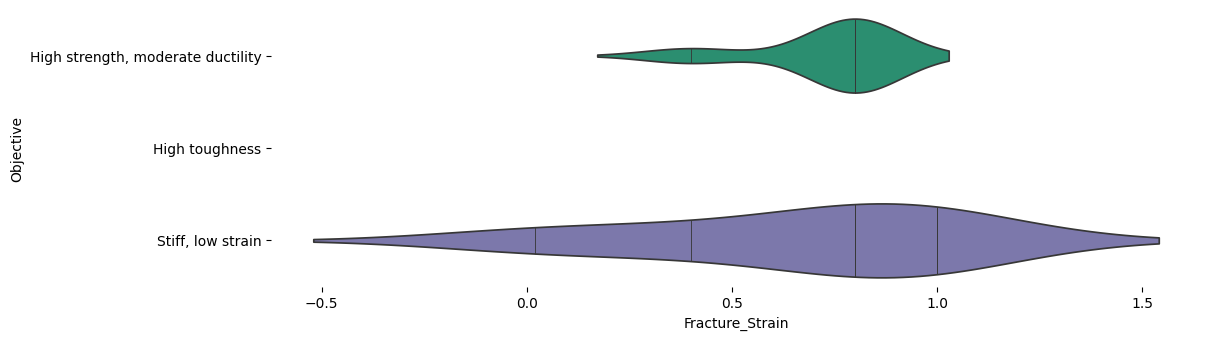

In [ ]:
# @title Objective vs Fracture_Strain

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(inv_results['Objective'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(inv_results, x='Fracture_Strain', y='Objective', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-2252264030.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(inv_results, x='UTS_kPa', y='family', inner='stick', palette='Dark2')


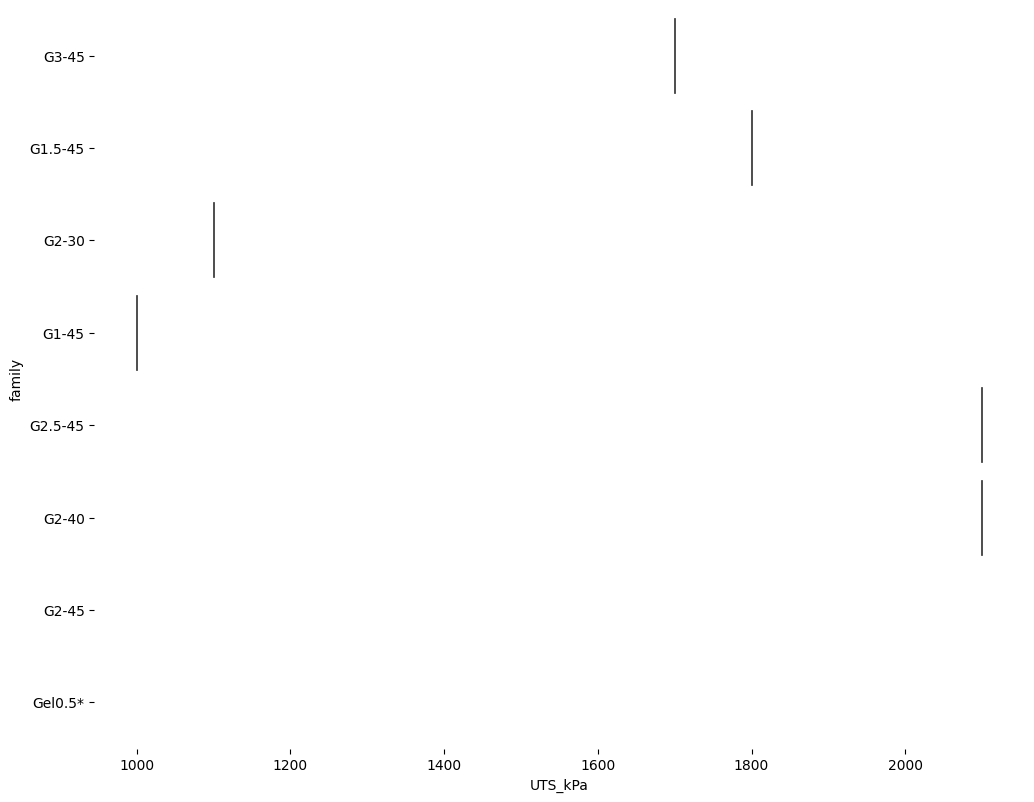

In [ ]:
# @title family vs UTS_kPa

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(inv_results['family'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(inv_results, x='UTS_kPa', y='family', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-329928810.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(inv_results, x='UTS_kPa', y='source', inner='stick', palette='Dark2')


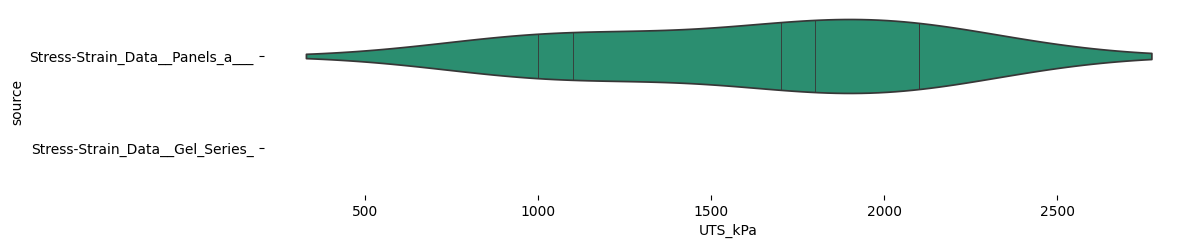

In [ ]:
# @title source vs UTS_kPa

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(inv_results['source'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(inv_results, x='UTS_kPa', y='source', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

/tmp/ipython-input-1848965666.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(inv_results, x='UTS_kPa', y='Objective', inner='stick', palette='Dark2')


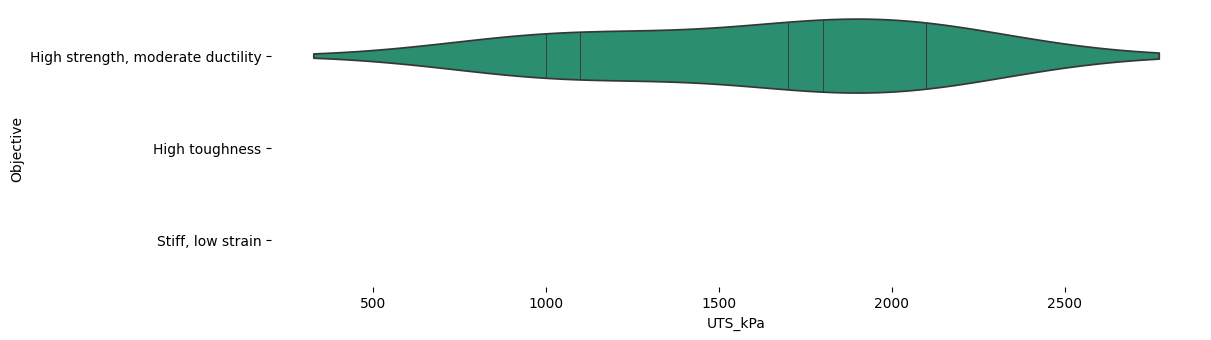

In [ ]:
# @title Objective vs UTS_kPa

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(inv_results['Objective'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(inv_results, x='UTS_kPa', y='Objective', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

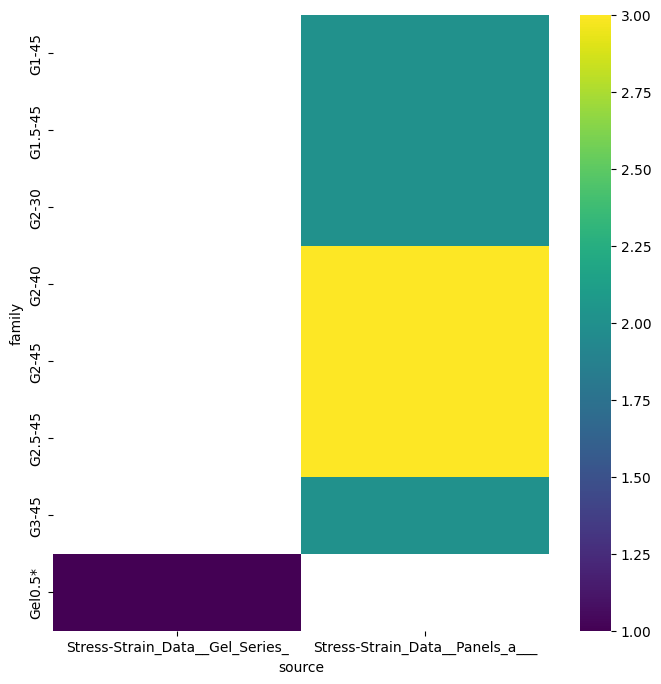

In [ ]:
# @title source vs family

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['family'].value_counts()
    for x_label, grp in inv_results.groupby('source')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('source')
_ = plt.ylabel('family')

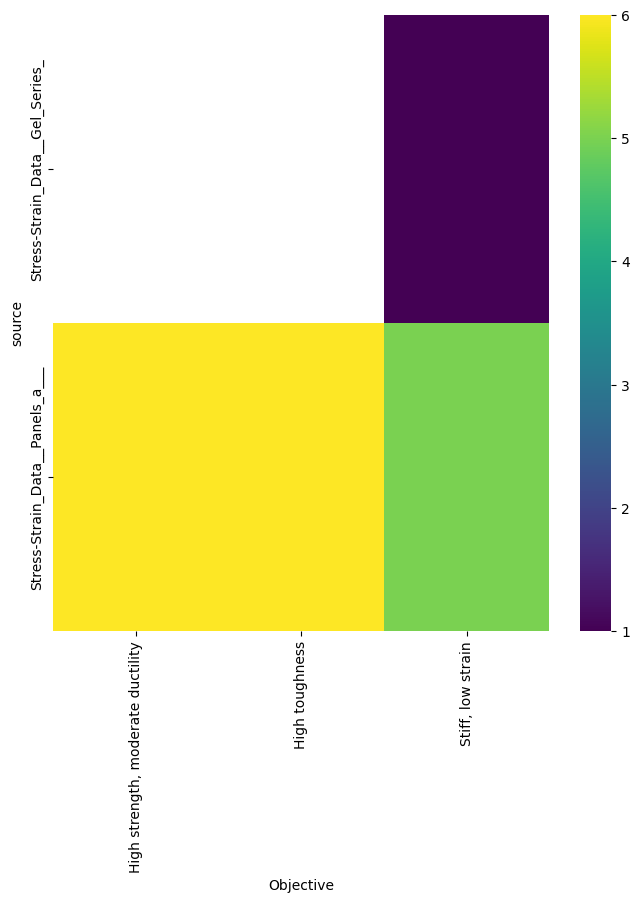

In [ ]:
# @title Objective vs source

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['source'].value_counts()
    for x_label, grp in inv_results.groupby('Objective')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Objective')
_ = plt.ylabel('source')

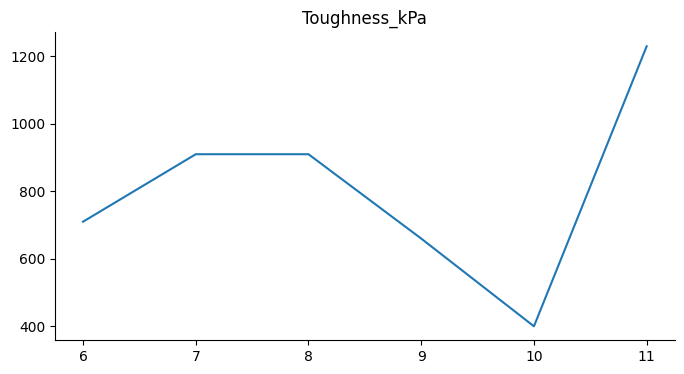

In [ ]:
# @title Toughness_kPa

from matplotlib import pyplot as plt
inv_results['Toughness_kPa'].plot(kind='line', figsize=(8, 4), title='Toughness_kPa')
plt.gca().spines[['top', 'right']].set_visible(False)

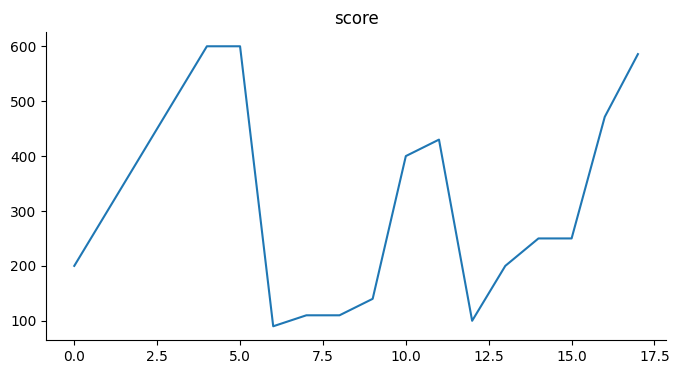

In [ ]:
# @title score

from matplotlib import pyplot as plt
inv_results['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

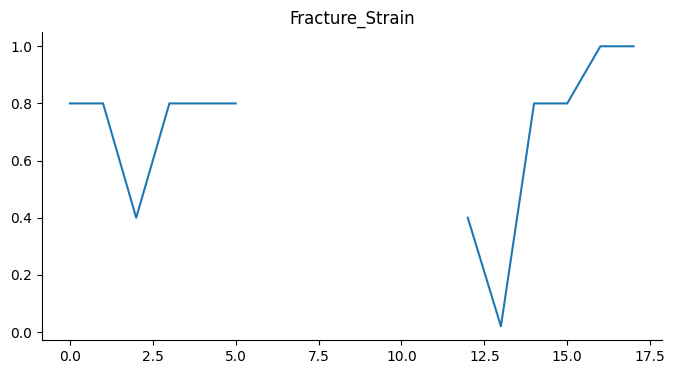

In [ ]:
# @title Fracture_Strain

from matplotlib import pyplot as plt
inv_results['Fracture_Strain'].plot(kind='line', figsize=(8, 4), title='Fracture_Strain')
plt.gca().spines[['top', 'right']].set_visible(False)

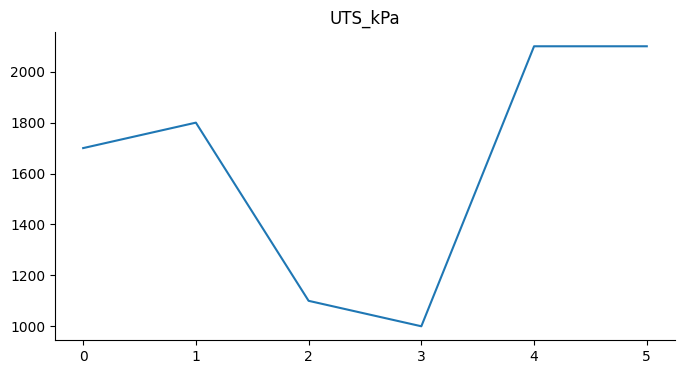

In [ ]:
# @title UTS_kPa

from matplotlib import pyplot as plt
inv_results['UTS_kPa'].plot(kind='line', figsize=(8, 4), title='UTS_kPa')
plt.gca().spines[['top', 'right']].set_visible(False)

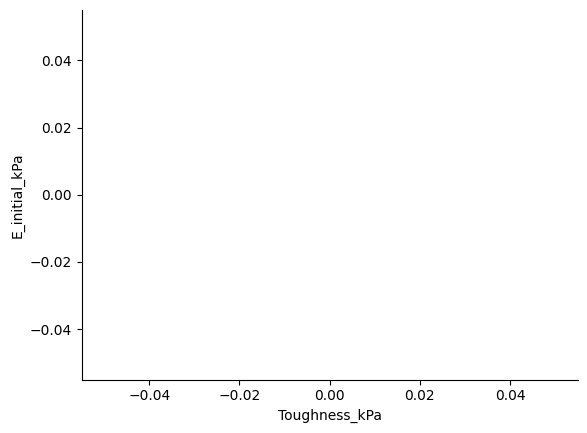

In [ ]:
# @title Toughness_kPa vs E_initial_kPa

from matplotlib import pyplot as plt
inv_results.plot(kind='scatter', x='Toughness_kPa', y='E_initial_kPa', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

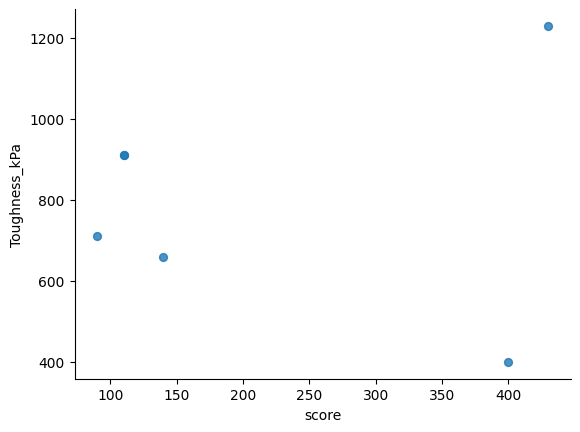

In [ ]:
# @title score vs Toughness_kPa

from matplotlib import pyplot as plt
inv_results.plot(kind='scatter', x='score', y='Toughness_kPa', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

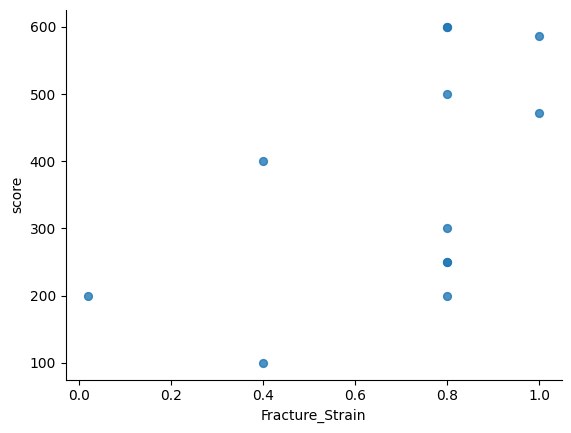

In [ ]:
# @title Fracture_Strain vs score

from matplotlib import pyplot as plt
inv_results.plot(kind='scatter', x='Fracture_Strain', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

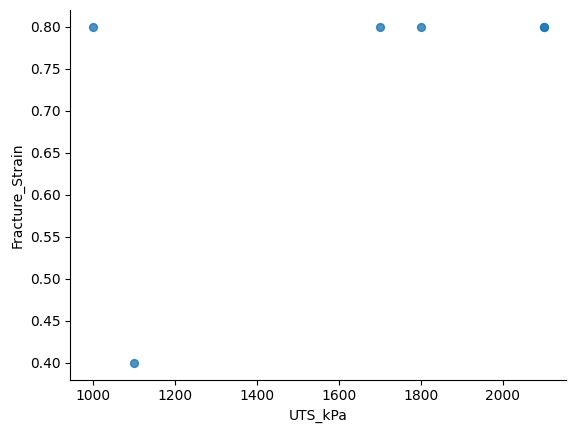

In [ ]:
# @title UTS_kPa vs Fracture_Strain

from matplotlib import pyplot as plt
inv_results.plot(kind='scatter', x='UTS_kPa', y='Fracture_Strain', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

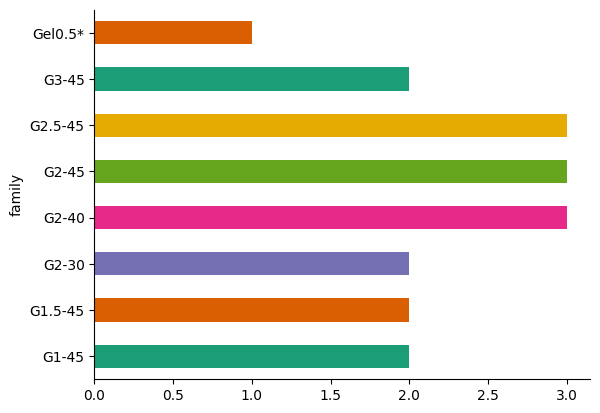

In [ ]:
# @title family

from matplotlib import pyplot as plt
import seaborn as sns
inv_results.groupby('family').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

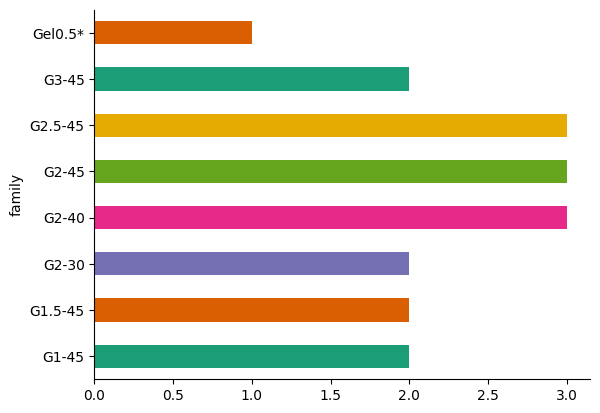

In [ ]:
# @title family

from matplotlib import pyplot as plt
import seaborn as sns
inv_results.groupby('family').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

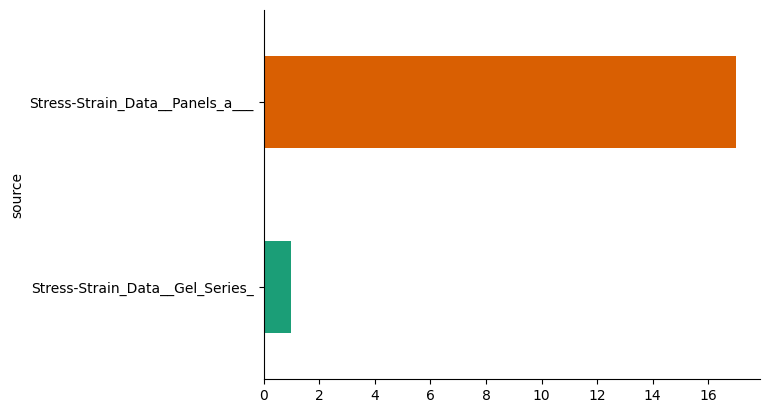

In [ ]:
# @title source

from matplotlib import pyplot as plt
import seaborn as sns
inv_results.groupby('source').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

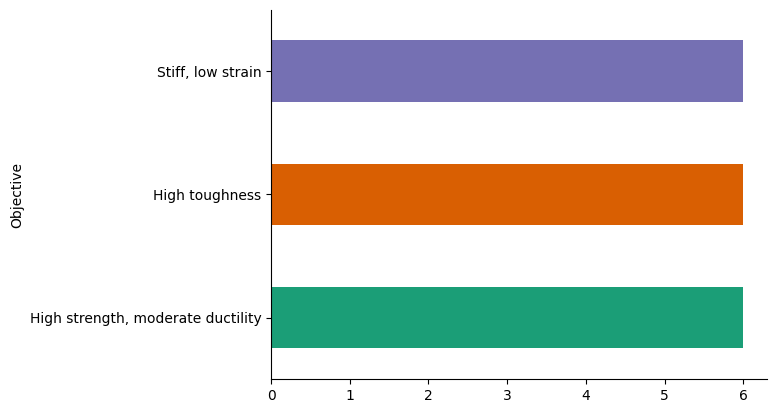

In [ ]:
# @title Objective

from matplotlib import pyplot as plt
import seaborn as sns
inv_results.groupby('Objective').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

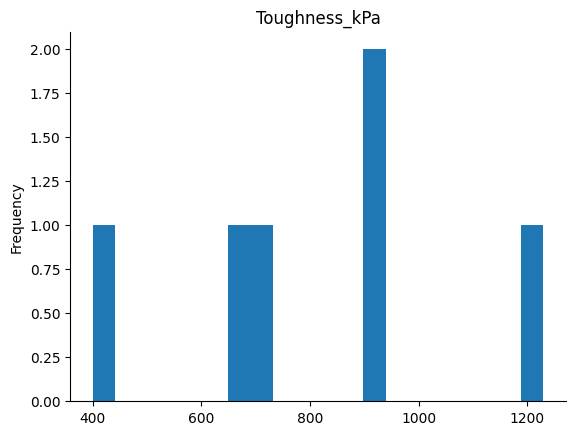

In [ ]:
# @title Toughness_kPa

from matplotlib import pyplot as plt
inv_results['Toughness_kPa'].plot(kind='hist', bins=20, title='Toughness_kPa')
plt.gca().spines[['top', 'right',]].set_visible(False)

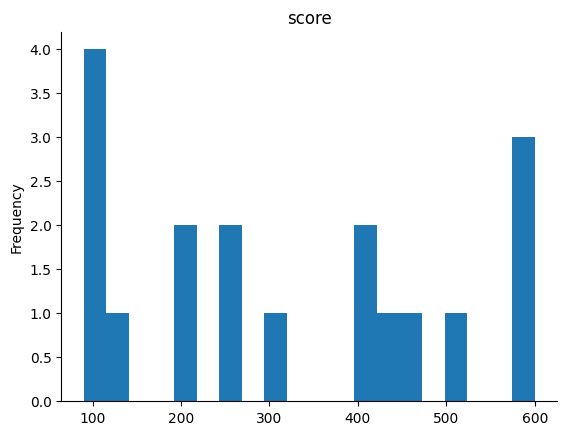

In [ ]:
# @title score

from matplotlib import pyplot as plt
inv_results['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

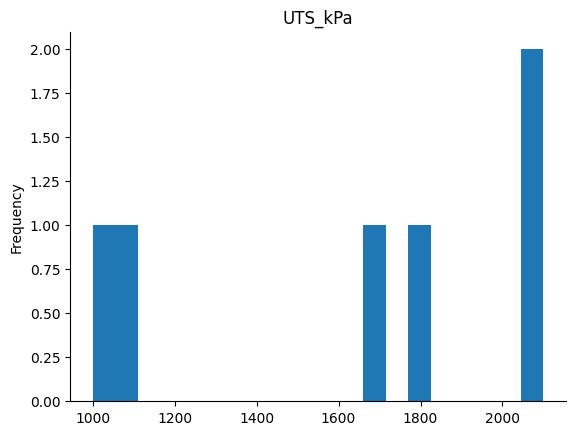

In [ ]:
# @title UTS_kPa

from matplotlib import pyplot as plt
inv_results['UTS_kPa'].plot(kind='hist', bins=20, title='UTS_kPa')
plt.gca().spines[['top', 'right',]].set_visible(False)

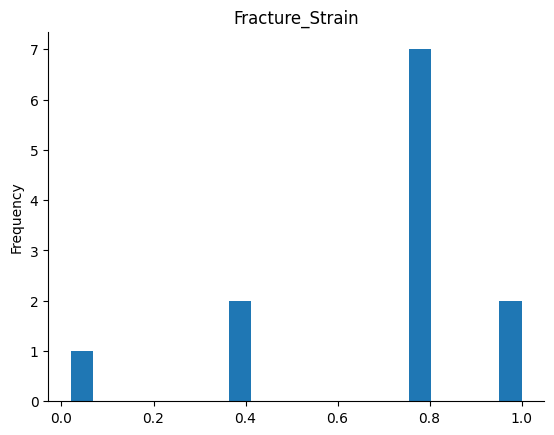

In [ ]:
# @title Fracture_Strain

from matplotlib import pyplot as plt
inv_results['Fracture_Strain'].plot(kind='hist', bins=20, title='Fracture_Strain')
plt.gca().spines[['top', 'right',]].set_visible(False)

📘 Overview of the Notebook

The notebook you're referring to is a Python script that uses machine learning to analyze and predict properties of materials, specifically PAAm hydrogels. Here's a simplified explanation of what each part does:

1. Importing Necessary Libraries
import pandas as pd
import numpy as np
import re
import os


pandas: Helps in handling and analyzing data in table format (like spreadsheets).

numpy: Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.

re: Used for working with regular expressions, which are patterns used to match character combinations in strings.

os: Provides a way to interact with the operating system, like reading or writing files.

2. Loading Data from an Excel File
file_path = "/content/paam_hydrogel_stress_strain_data_v2.xlsx"
xls = pd.ExcelFile(file_path)


This code loads an Excel file containing data about PAAm hydrogels. The file is expected to be uploaded to the Colab environment.

3. Normalizing Data
def _normalize_strain(e, is_percent):
    e = np.asarray(e, dtype=float)
    if not is_percent:
        return e
    emax = np.nanmax(e) if np.isfinite(e).any() else 0.0
    if emax > 100:
        return e / 10000.0
    return e / 100.0


This function adjusts the strain data to a consistent scale. Strain is a measure of how much a material deforms under stress. If the data is in percentage, it's converted to a fraction for easier analysis.

4. Calculating Material Properties
def _compute_properties(strain, stress, strain_is_percent=False, strain_col="", stress_col=""):
    s_raw = np.asarray(stress, dtype=float)
    e_raw = np.asarray(strain, dtype=float)
    s = _normalize_stress(s_raw, stress_col)
    e = _normalize_strain(e_raw, strain_is_percent, strain_col)
    ...


This function calculates key properties of the material:

E_initial_kPa: The initial stiffness of the material.

UTS_kPa: Ultimate tensile strength, the maximum stress the material can withstand.

Fracture_Strain: The strain at which the material breaks.

Toughness_kPa: The energy absorbed by the material before breaking.

5. Processing Data from Excel Sheets
def _tidy_wide(df, source_name):
    ...


This function processes data from each sheet in the Excel file, extracting relevant information and calculating the material properties for each dataset.

6. Performing Inverse Design Search
def inverse_design_search(library: pd.DataFrame, targets: dict, weights: dict=None, k: int=6) -> pd.DataFrame:
    ...


This function compares the calculated material properties with desired target values. It finds the top k materials whose properties are closest to the targets. This is useful for identifying materials that meet specific performance criteria.

7. Displaying Results
import caas_jupyter_tools
caas_jupyter_tools.display_dataframe_to_user("Inverse Design Results", inv_results)


This code displays the results of the inverse design search in a user-friendly table format within the Colab notebook.

🔍 Summary

In simple terms, this notebook:

Loads data about PAAm hydrogels.

Processes and normalizes the data.

Calculates important material properties.

Compares these properties with desired targets.

Identifies the best materials that meet the targets.